In [1]:
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from fastai.vision import *

In [3]:
torch.cuda.set_device(1)

In [4]:
met_image_data = '/data/kaggle/met/photographs-02-08-19.csv'
met_df = pd.read_csv(met_image_data)

In [ ]:
met_df.head(10)

In [5]:
def extract_image_path(row):
    object_id = row['object_id']
    return f'{object_id}.jpg'
met_df['image_path'] = met_df.apply (lambda row: extract_image_path(row),axis=1)
# original_met_df = met_df.copy()

In [7]:
photo_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.1, max_warp=0.2, max_rotate=20.0)
batch_size = 1024
fastai_image_databunch = (ImageItemList.from_df(df=met_df, path='/data/kaggle/met/', folder='tmp/64', cols='image_path')
                     .random_split_by_pct(valid_pct=0.2, seed=100)
                     .label_from_df(cols='object_end_date', label_cls=FloatList)
                     .transform(photo_tfms, size=64)
                     .databunch(bs=batch_size))

In [9]:
learn = create_cnn(fastai_image_databunch, models.resnet34, callback_fns=ShowGraph, loss_func=root_mean_squared_error).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


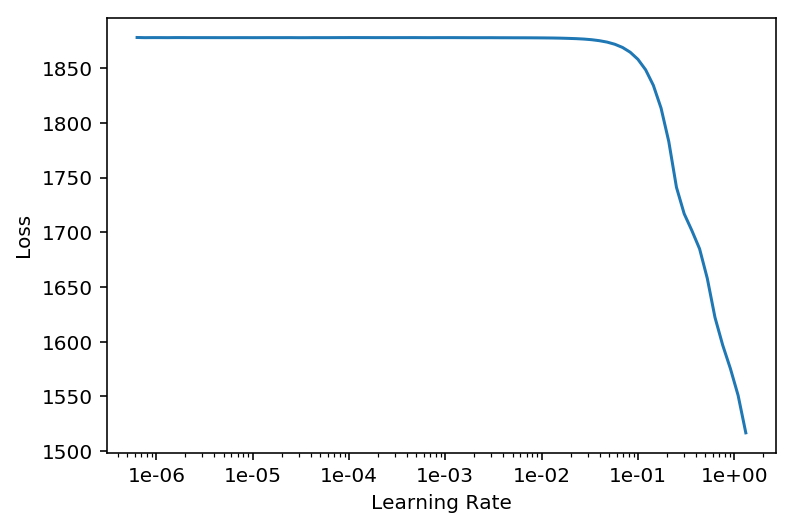

In [17]:
learn.lr_find()
learn.recorder.plot()

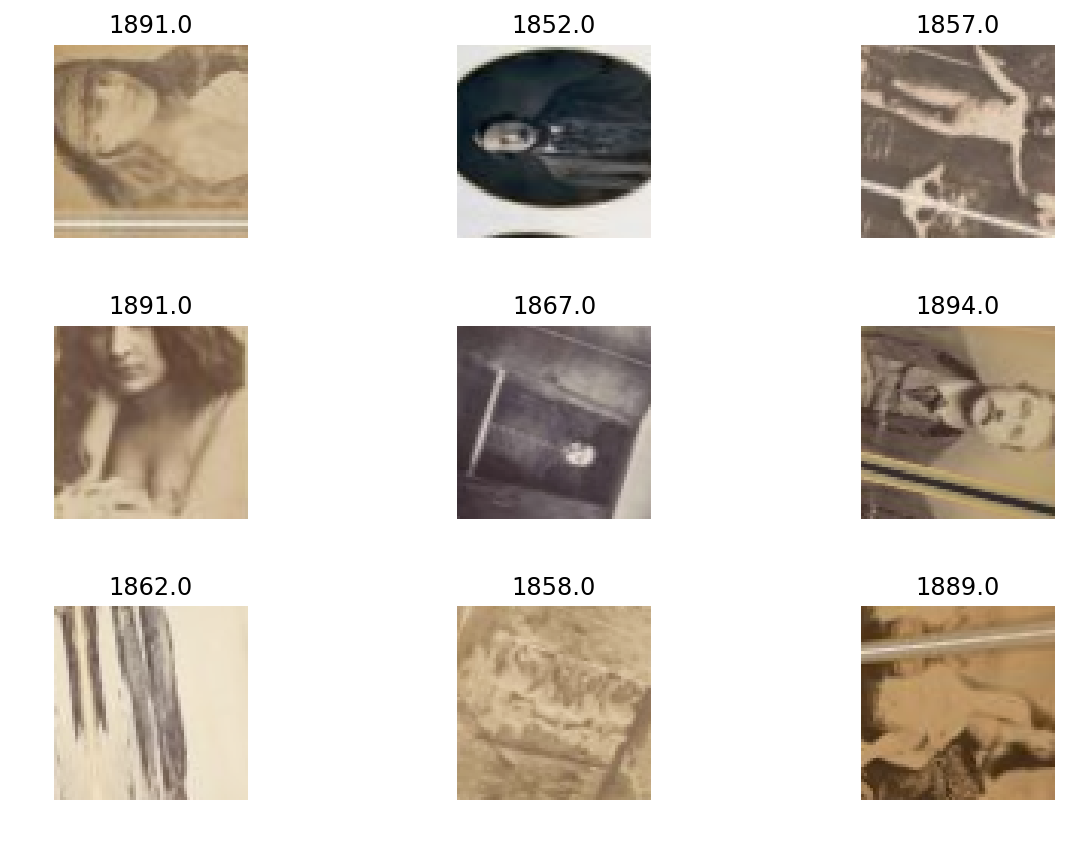

In [10]:
fastai_image_databunch.show_batch(rows=3, figsize=(9,6))

In [10]:
# learn.recorder.plot()

epoch,train_loss,valid_loss
1,1877.889160,1876.707031
2,1877.196411,1874.875366
3,1876.011475,1871.516113
4,1874.024536,1864.786011
5,1870.444336,1853.396973
6,1864.084351,1831.288574
7,1852.968994,1785.429565
8,1833.732788,1709.540894
9,1801.000122,1577.658447
10,1746.454712,1371.663452


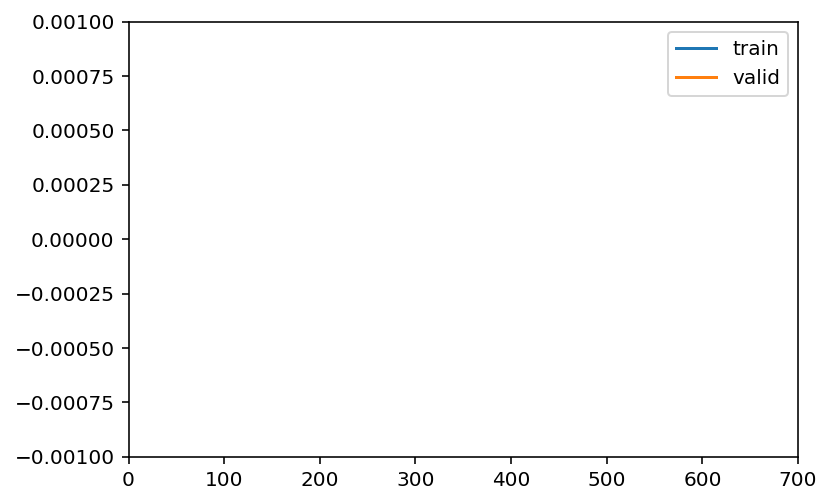

In [11]:
learn.fit_one_cycle(100, 1e-1)

In [21]:
learn.save('when-dat-photo-v1-resnet34-i64-b1024-e50-l2-w-pt-r100-v0.2')

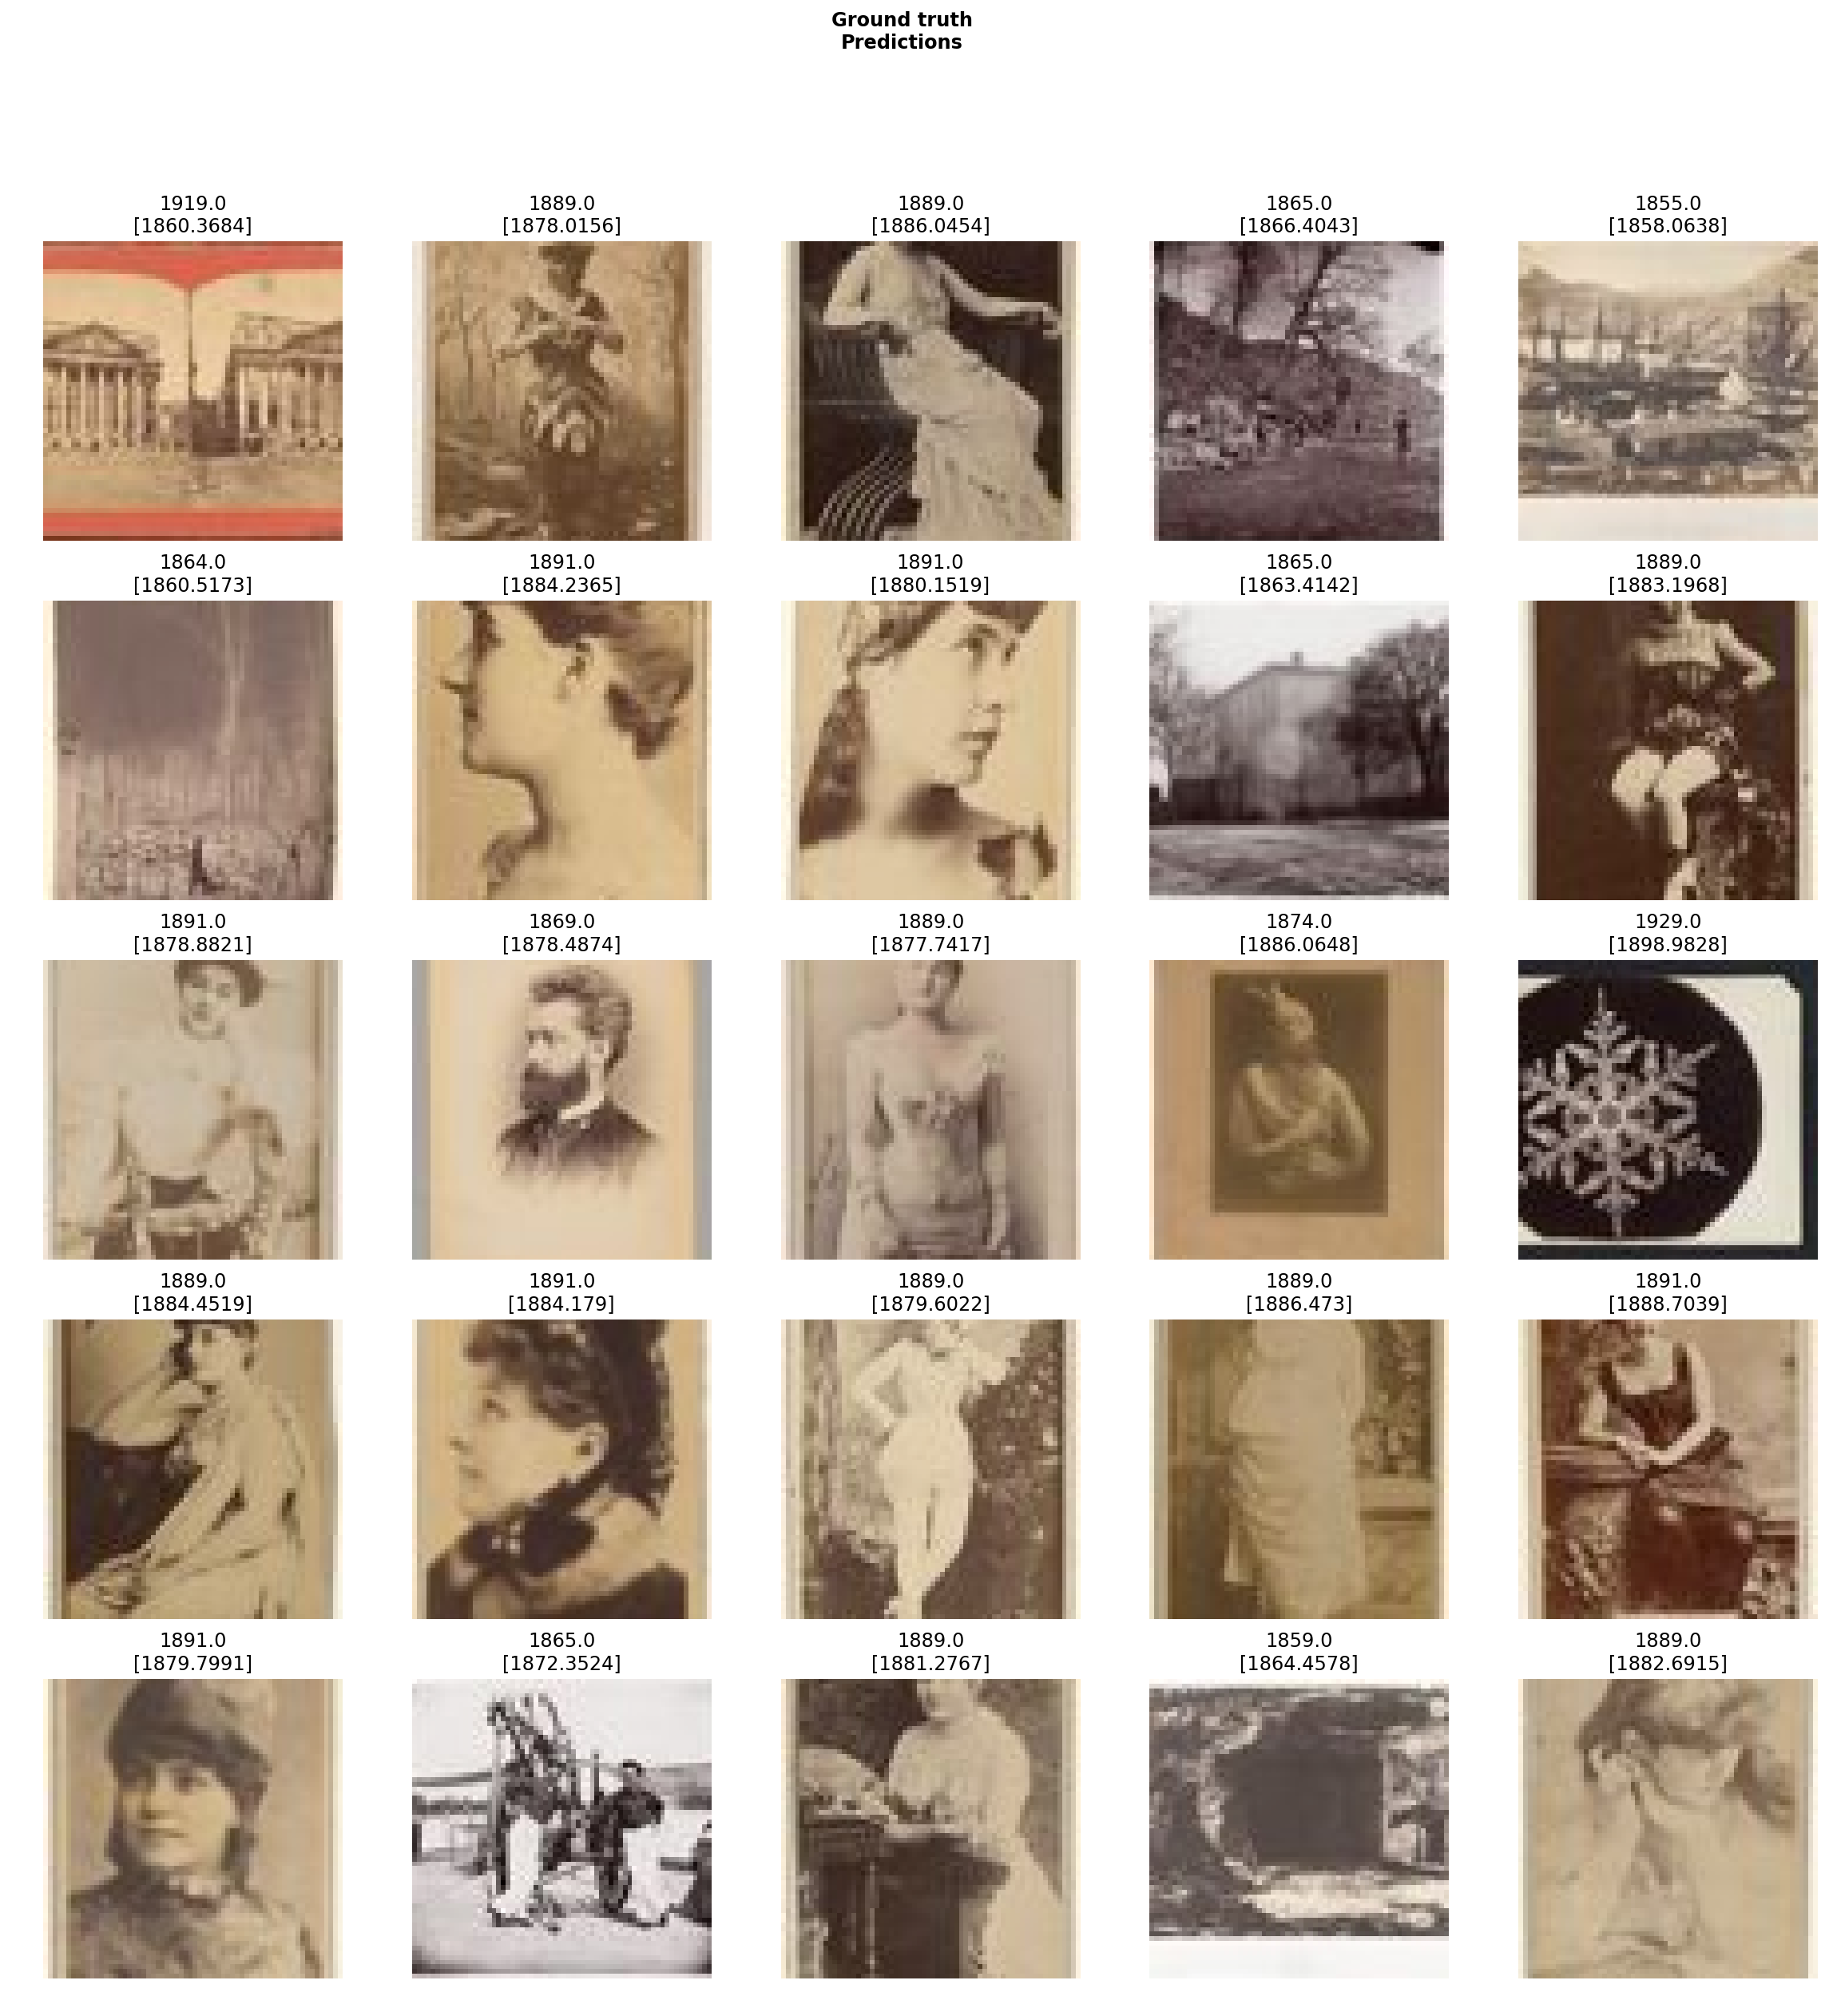

In [12]:
learn32 = learn.to_fp32()
learn32.show_results(rows=5)

Run: when-dat-photo-v1-resnet-50-i64-b256-e50-l2-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1878.251221,1877.588501
2,1877.956421,1876.980835
3,1877.458130,1875.531006
4,1876.018677,1871.146851
5,1871.881470,1858.285889
6,1860.659668,1827.194214
7,1833.985352,1759.928101
8,1778.822510,1630.933960
9,1677.664429,1408.155273
10,1509.761841,1088.206909


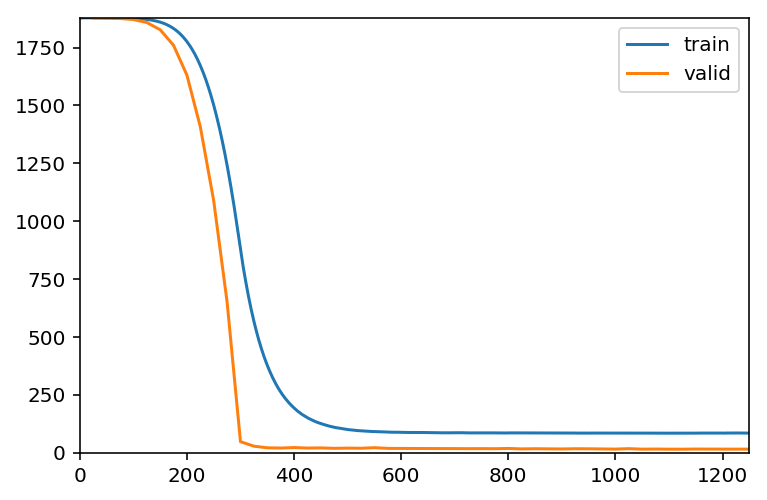

Run: when-dat-photo-v1-resnet-50-i64-b256-e50-l1-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1876.069580,1872.985718
2,1865.393188,1844.266479
3,1822.923096,1705.672974
4,1671.207275,1226.561646
5,1214.850830,157.092545
6,782.962341,43.982227
7,501.939880,80.103859
8,334.761169,28.641859
9,235.320984,21.291096
10,175.679749,20.147758


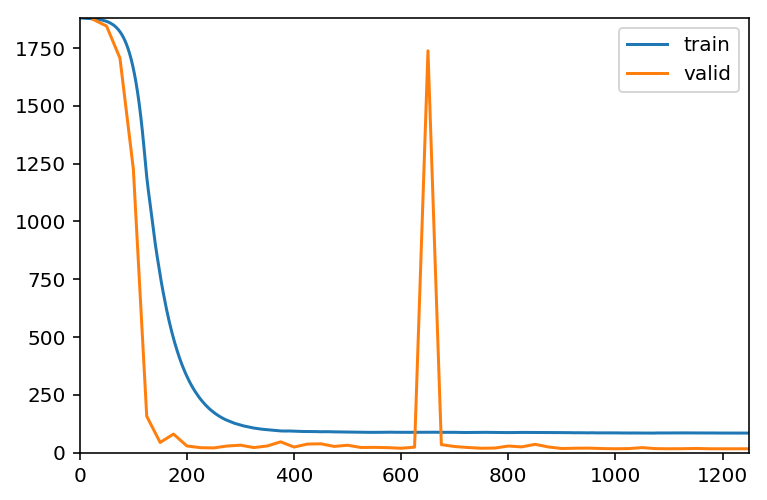

Run: when-dat-photo-v1-resnet-50-i64-b256-e100-l2-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1878.257690,1877.719116
2,1878.076538,1877.103394
3,1877.797363,1876.401001
4,1877.213867,1875.325439
5,1876.205933,1873.190552
6,1874.358398,1869.259399
7,1870.897339,1861.976807
8,1864.489380,1849.129517
9,1853.395020,1825.603271
10,1834.990723,1788.790527


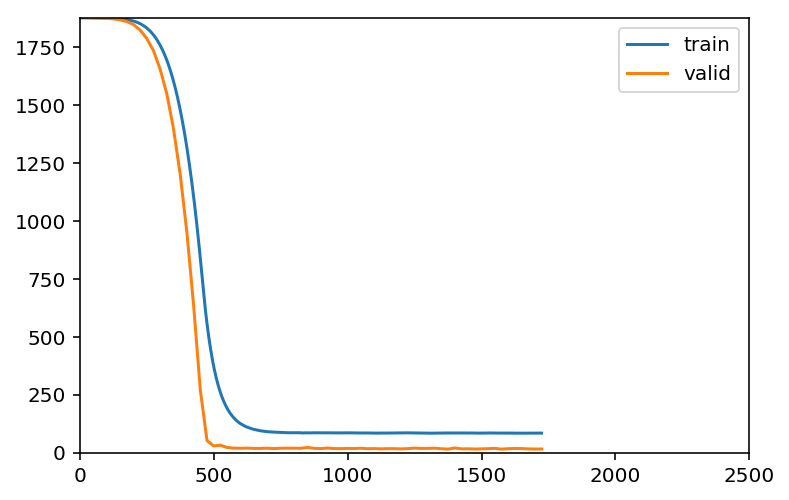

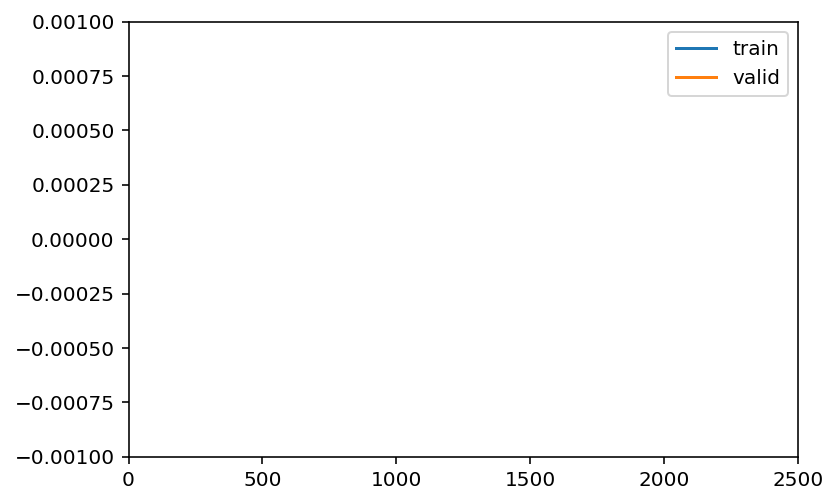

Run: when-dat-photo-v1-resnet-50-i128-b128-e50-l2-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1878.272339,1877.040771
2,1877.381592,1875.464844
3,1874.786133,1870.040039
4,1865.700562,1849.805176
5,1837.711792,1795.244629
6,1766.858521,1664.408691
7,1615.734741,1409.088867
8,1334.454102,969.704529
9,866.815063,291.756287
10,386.445770,30.048042


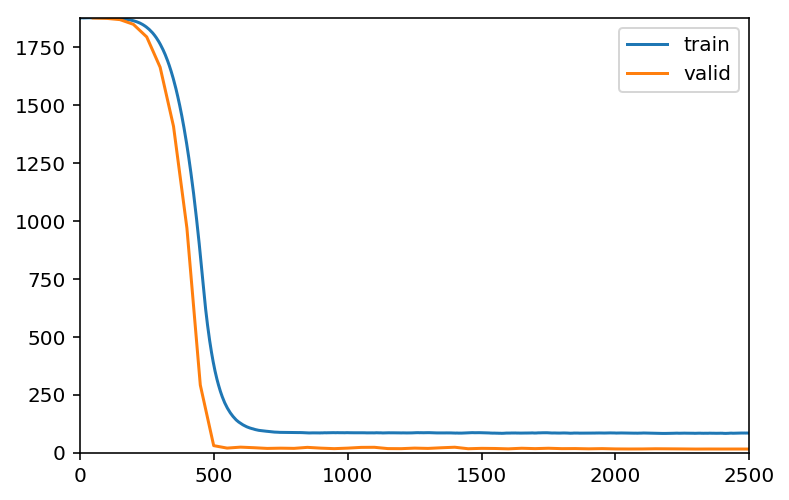

Run: when-dat-photo-v1-resnet-50-i128-b128-e50-l1-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1869.063354,1853.570190
2,1805.633423,1694.406860
3,1510.610107,985.032593
4,741.721497,31.412121
5,328.944641,27.836113
6,174.874969,21.745411
7,118.435295,27.211081
8,97.860443,45.455708
9,92.085846,62.707745
10,90.531807,23.681585


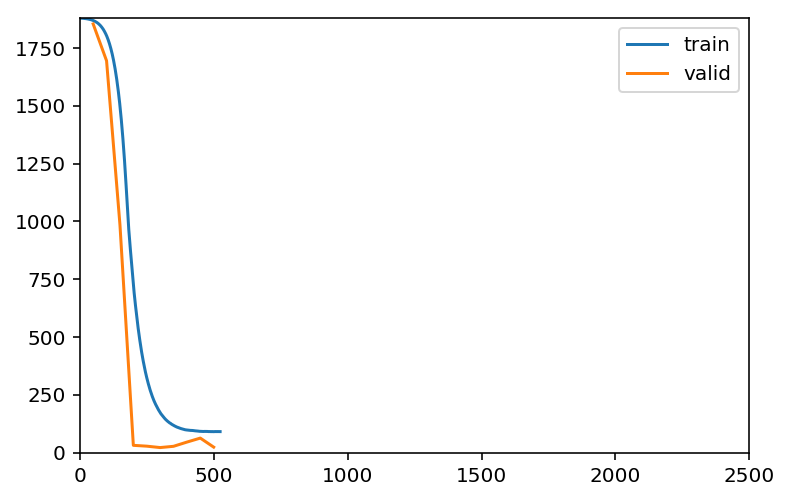

/home/edave/.local/share/virtualenvs/when-that-photo-RYuOSR_i/src/fastai/fastai/callbacks/fp16.py:90: UserWarning: You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: 512.0).
  warn(f"You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: {self.loss_scale}).")


Run: when-dat-photo-v1-resnet-50-i128-b128-e100-l2-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1878.095947,1877.121094
2,1877.470459,1876.082031
3,1876.296143,1874.076050
4,1873.614624,1868.976074
5,1868.099365,1859.710205
6,1857.257446,1840.125000
7,1837.424194,1809.479736
8,1803.078003,1757.927002
9,1746.955200,1677.883423
10,1659.500244,1550.953613


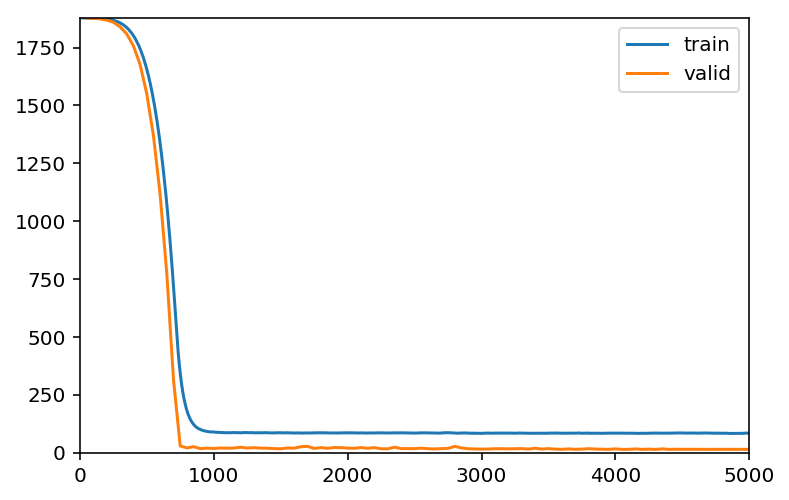

Run: when-dat-photo-v1-resnet-50-i128-b128-e100-l1-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1869.879517,1855.794434
2,1827.071167,1764.566162
3,1699.508057,1513.212036
4,1400.991821,976.094299
5,794.350098,38.297771
6,359.597351,25.572054
7,187.846680,25.888067
8,123.644730,26.433653
9,99.493065,20.343988
10,90.838554,20.764734


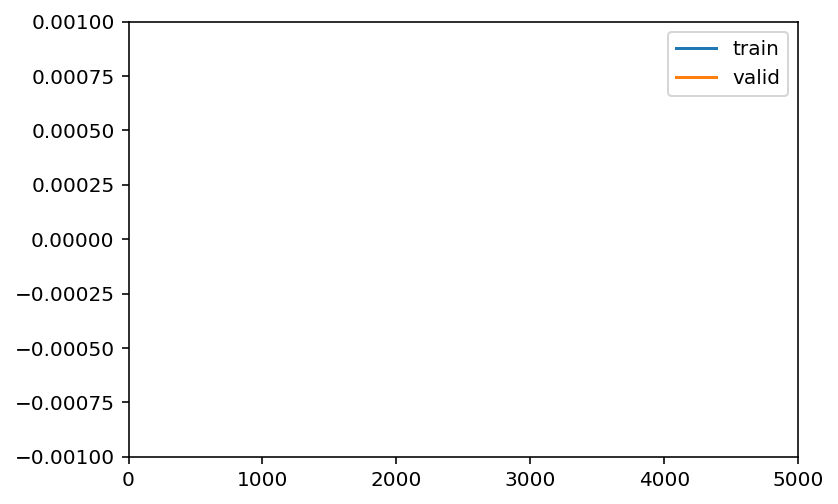

/home/edave/.local/share/virtualenvs/when-that-photo-RYuOSR_i/src/fastai/fastai/callbacks/fp16.py:90: UserWarning: You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: 512.0).
  warn(f"You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: {self.loss_scale}).")


Run: when-dat-photo-v1-resnet-50-i256-b64-e50-l2-w-pt-r100-v0.33


epoch,train_loss,valid_loss
1,1877.562988,1876.186401
2,1873.811157,1869.984619
3,1858.978271,1844.501221
4,1806.571777,1765.908447
5,1665.233887,1564.181885
6,1347.212158,1122.046753
7,730.509216,318.095520
8,184.607269,25.053999
9,100.867859,23.964617
10,88.725662,25.001158


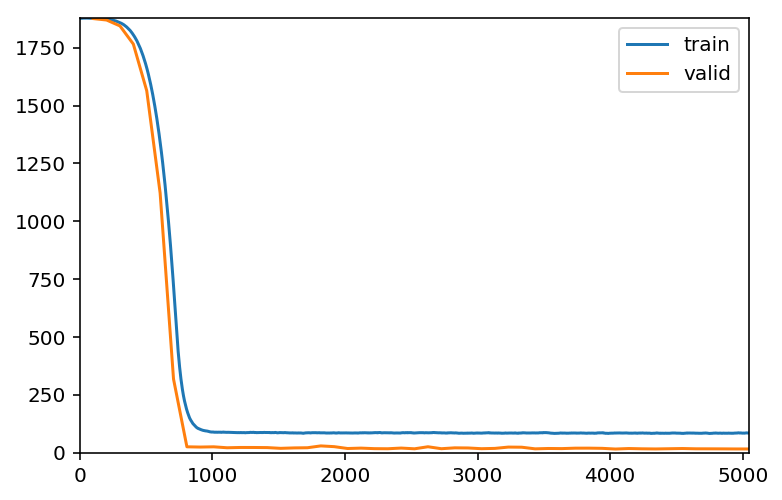

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 1; 7.77 GiB total capacity; 6.58 GiB already allocated; 23.50 MiB free; 108.58 MiB cached)

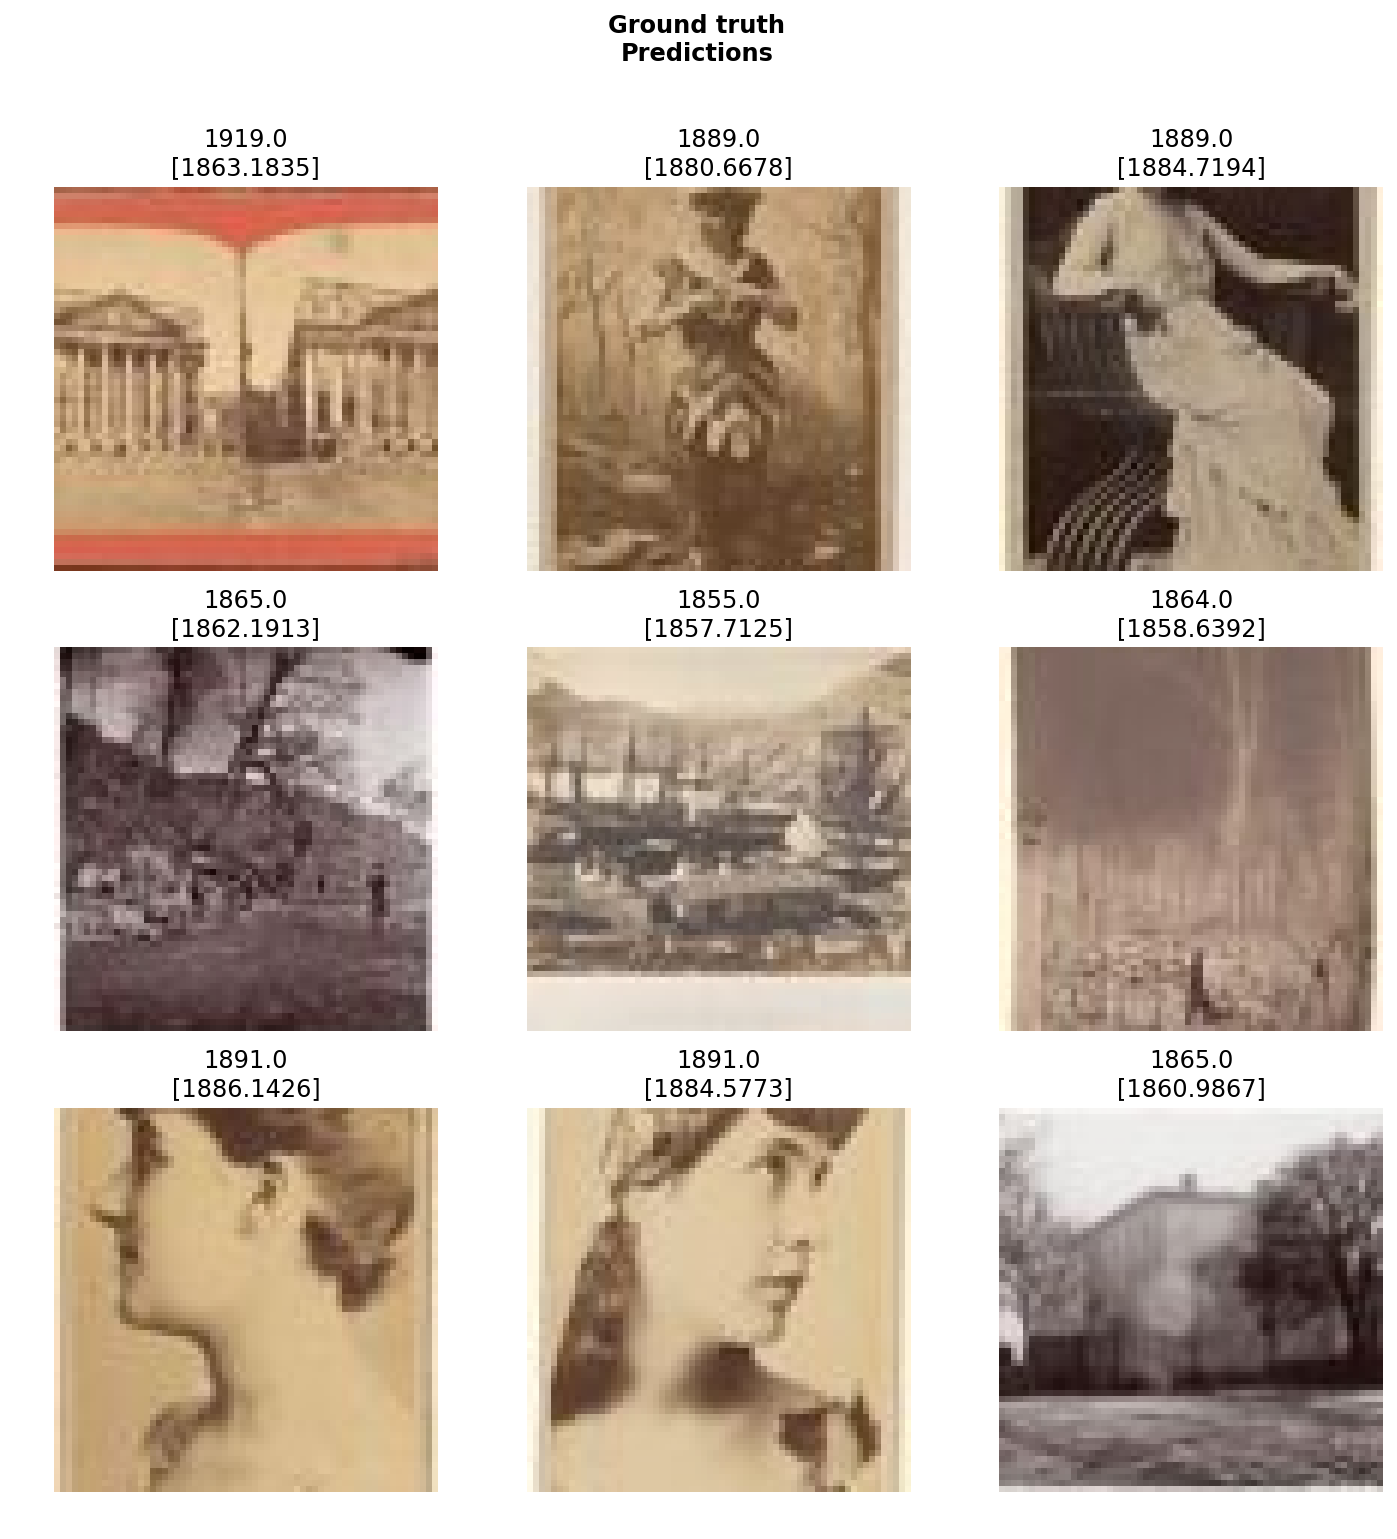

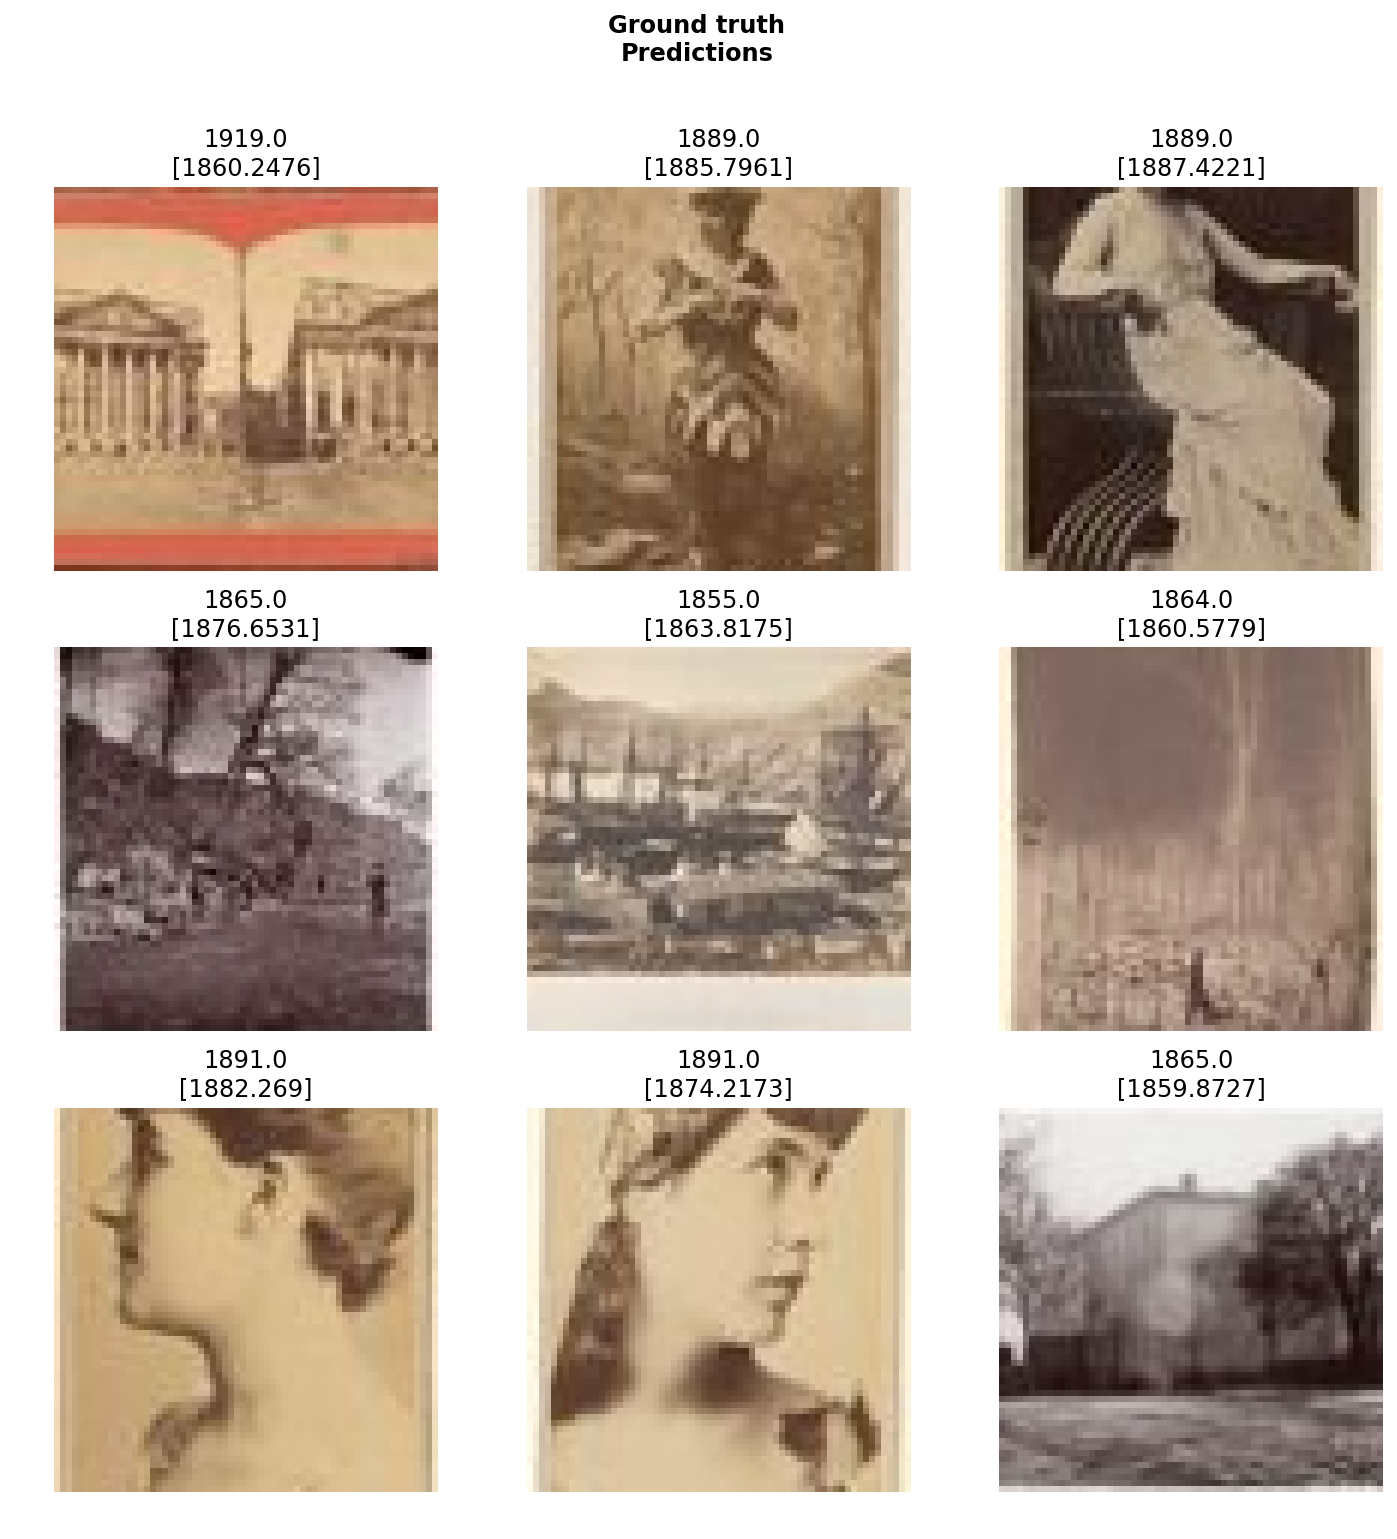

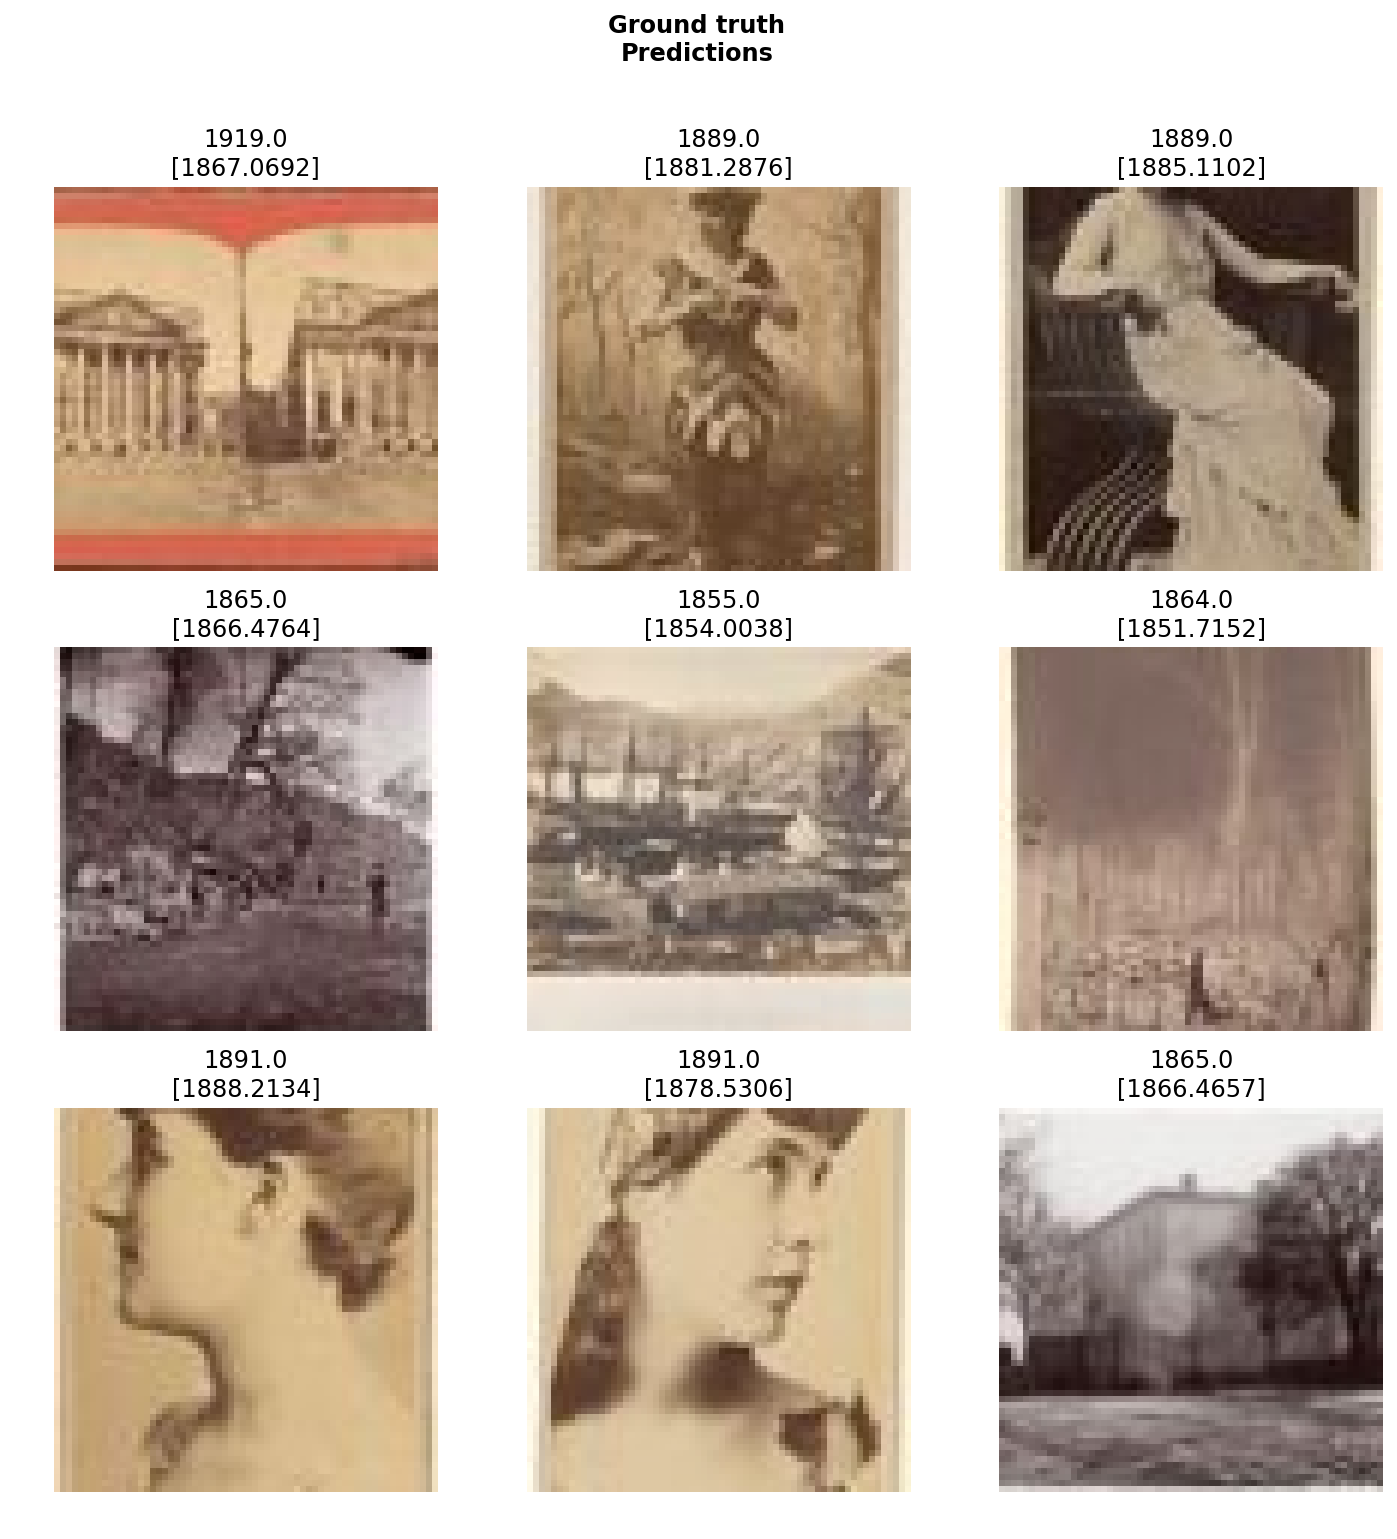

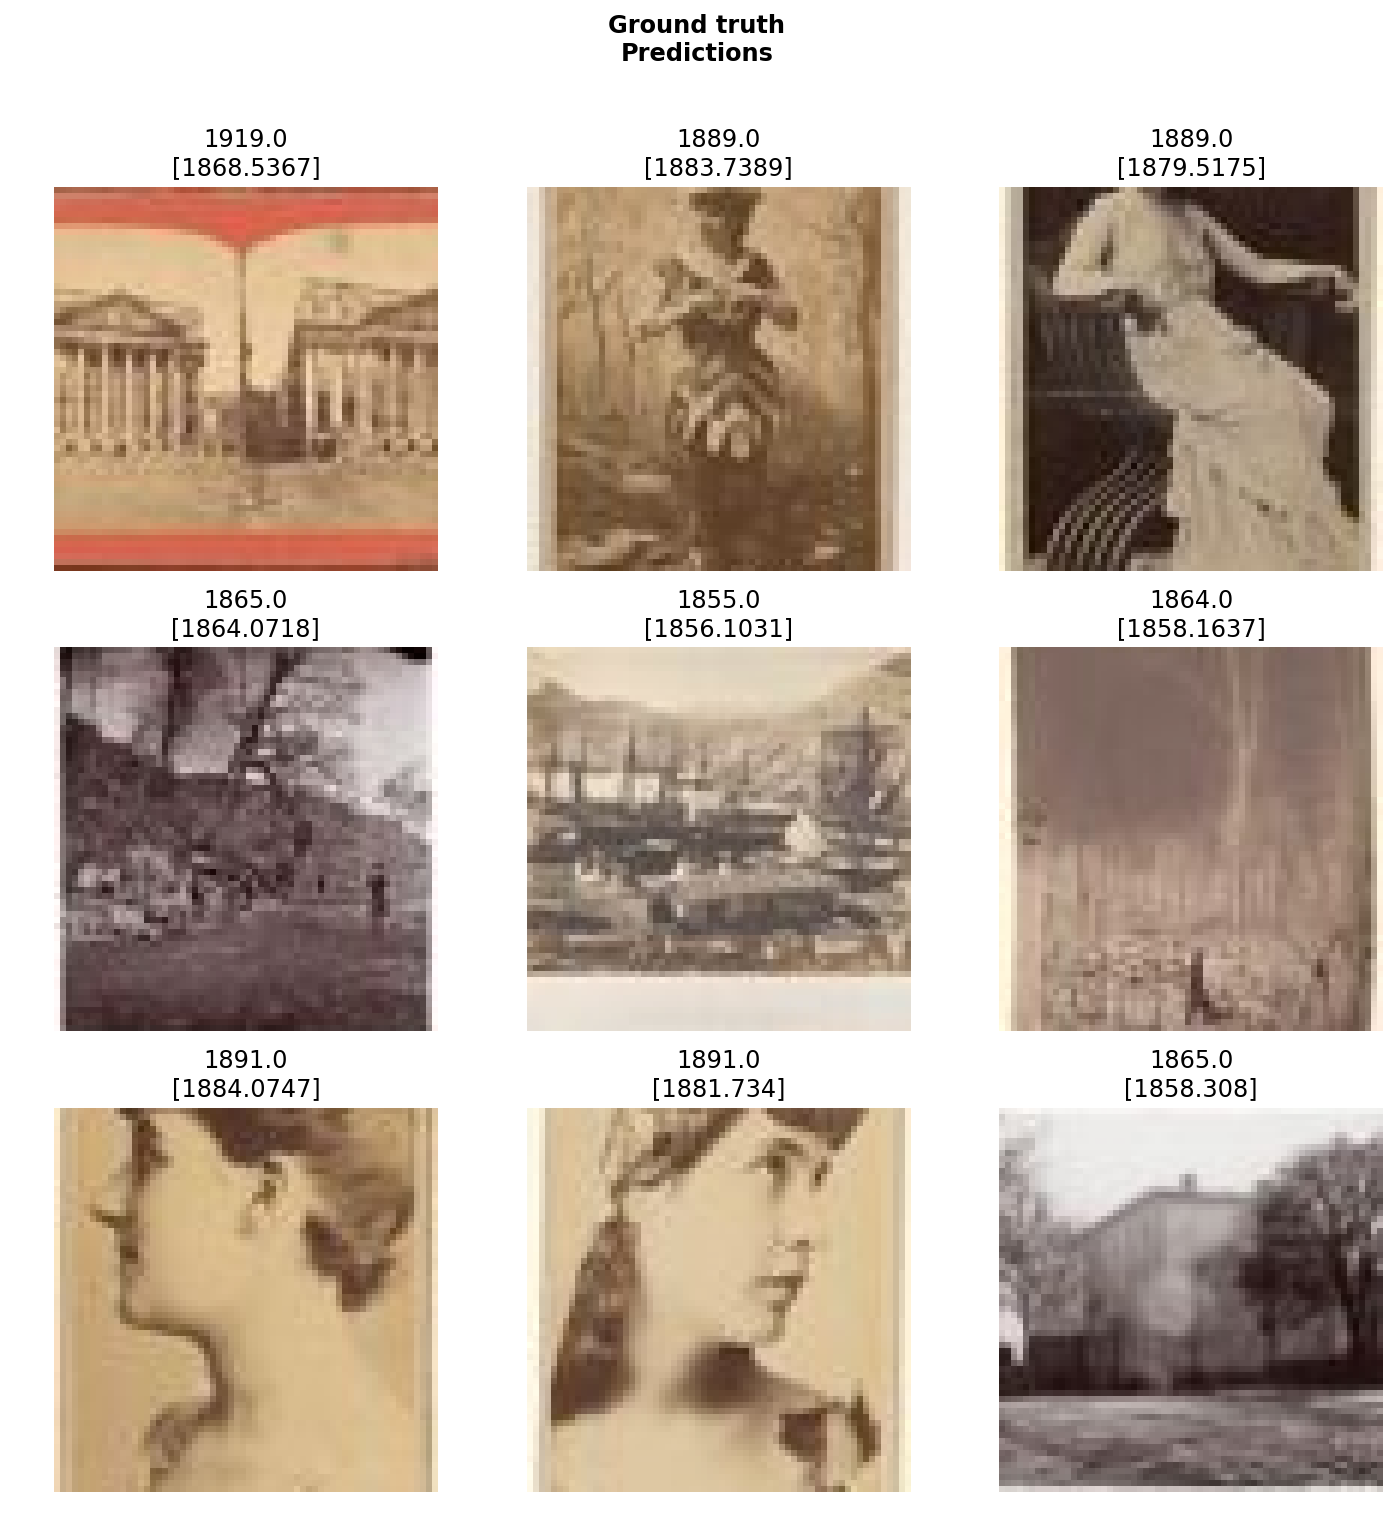

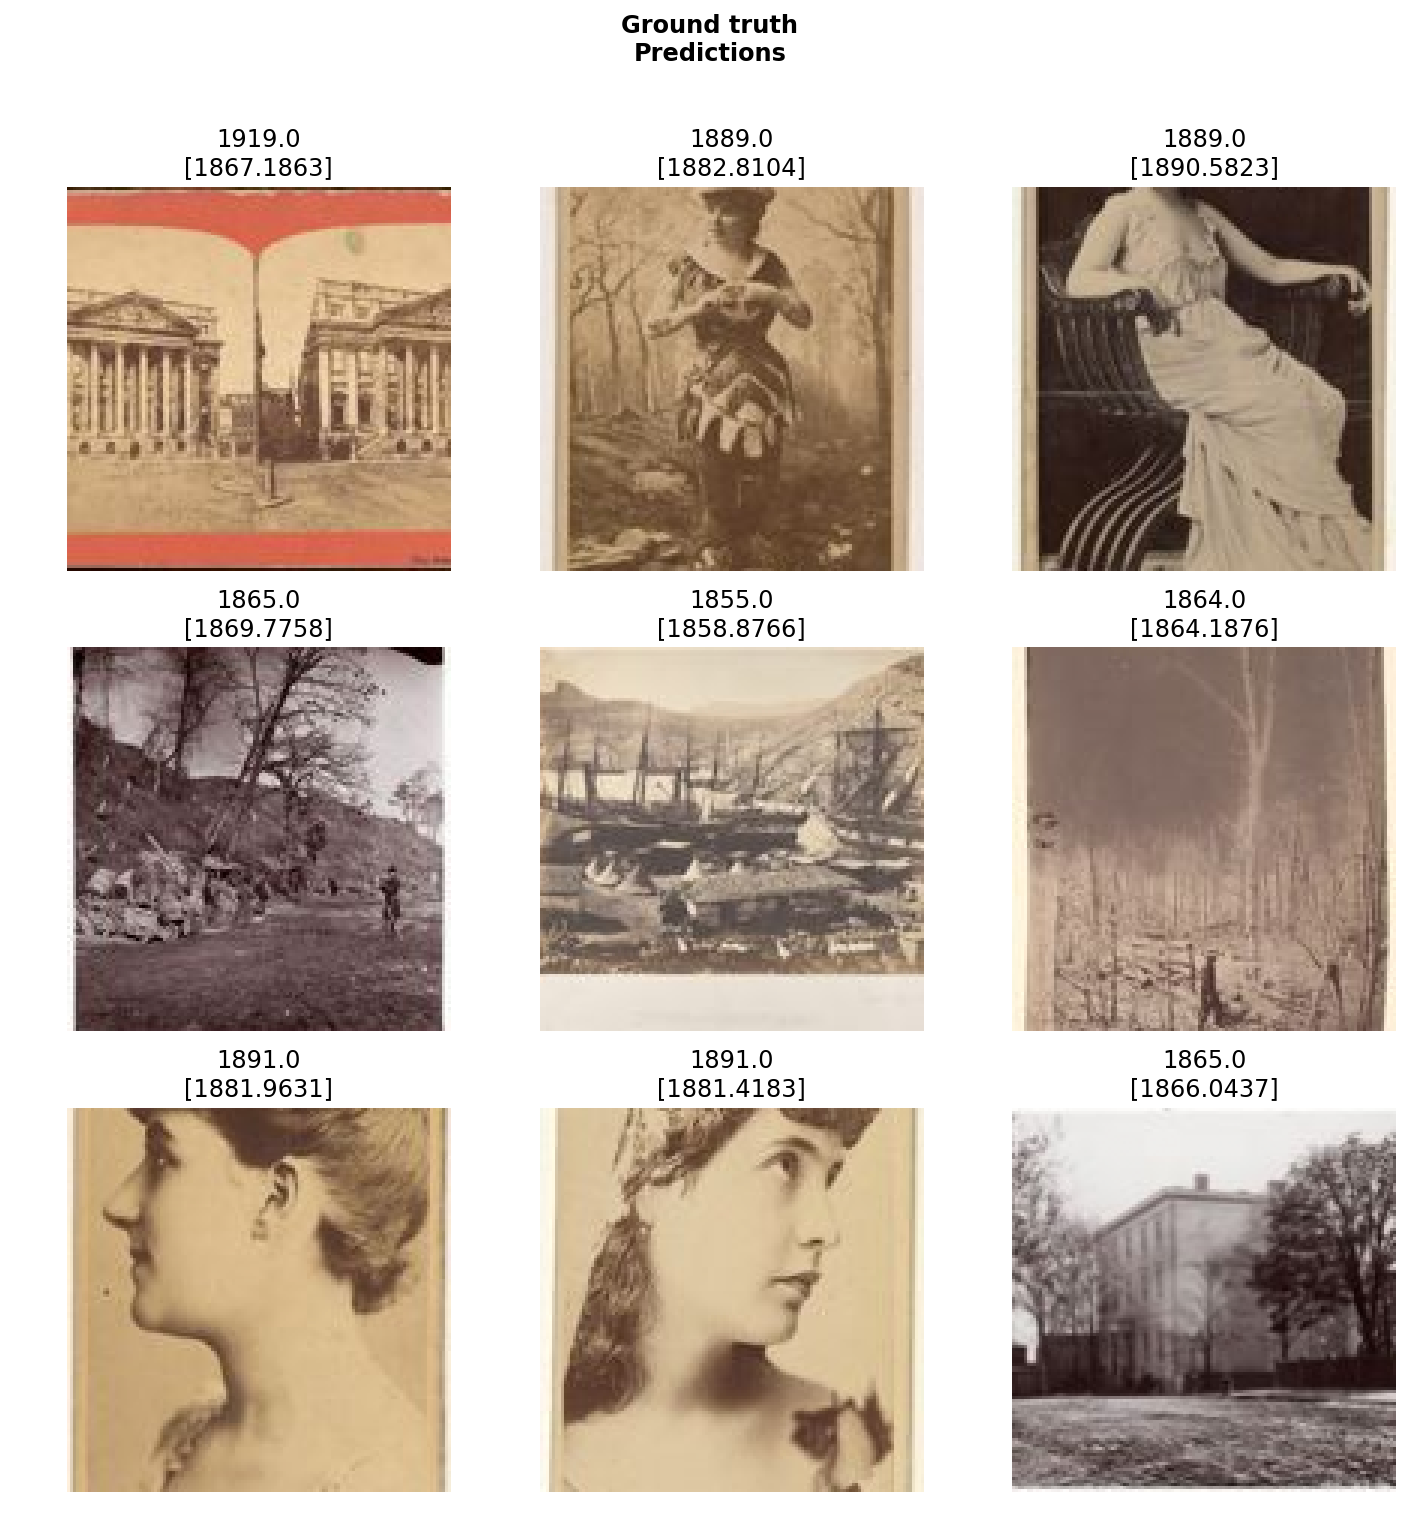

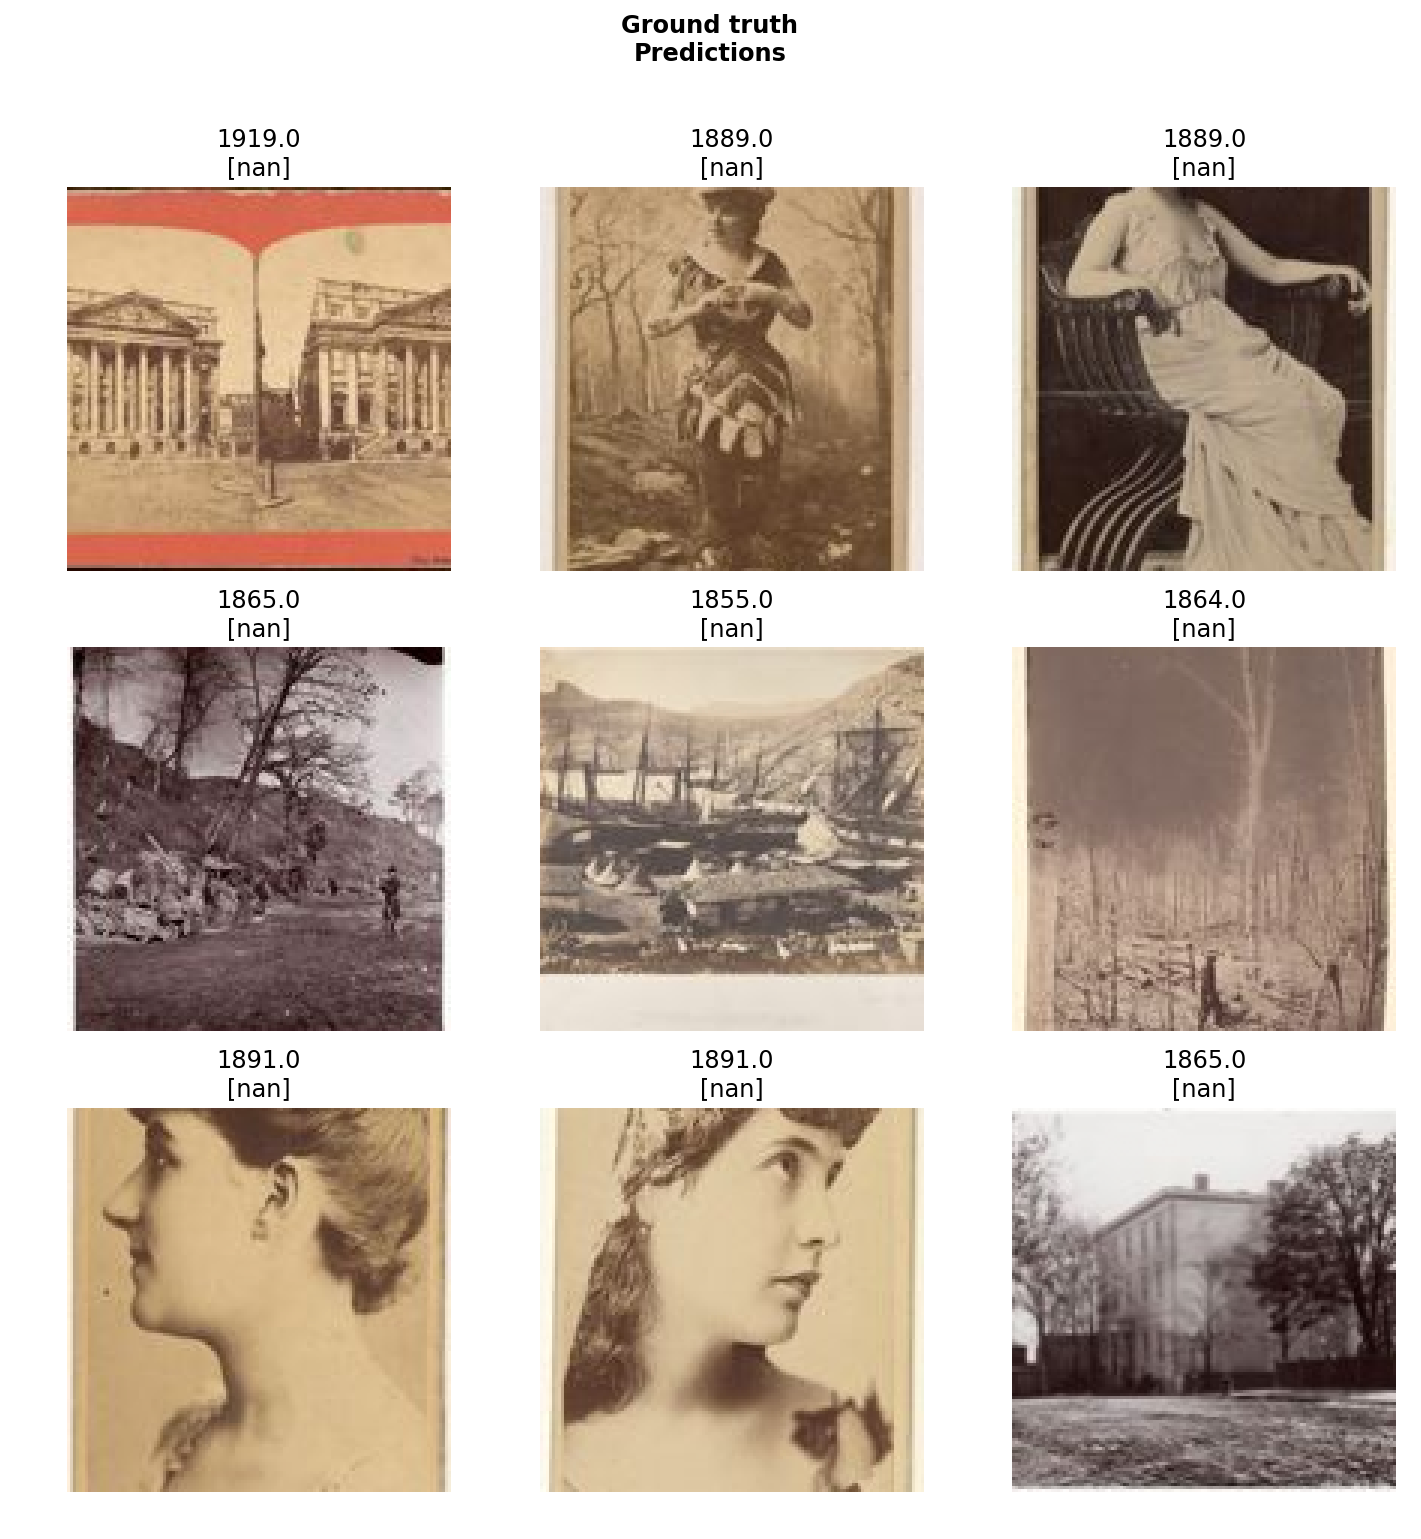

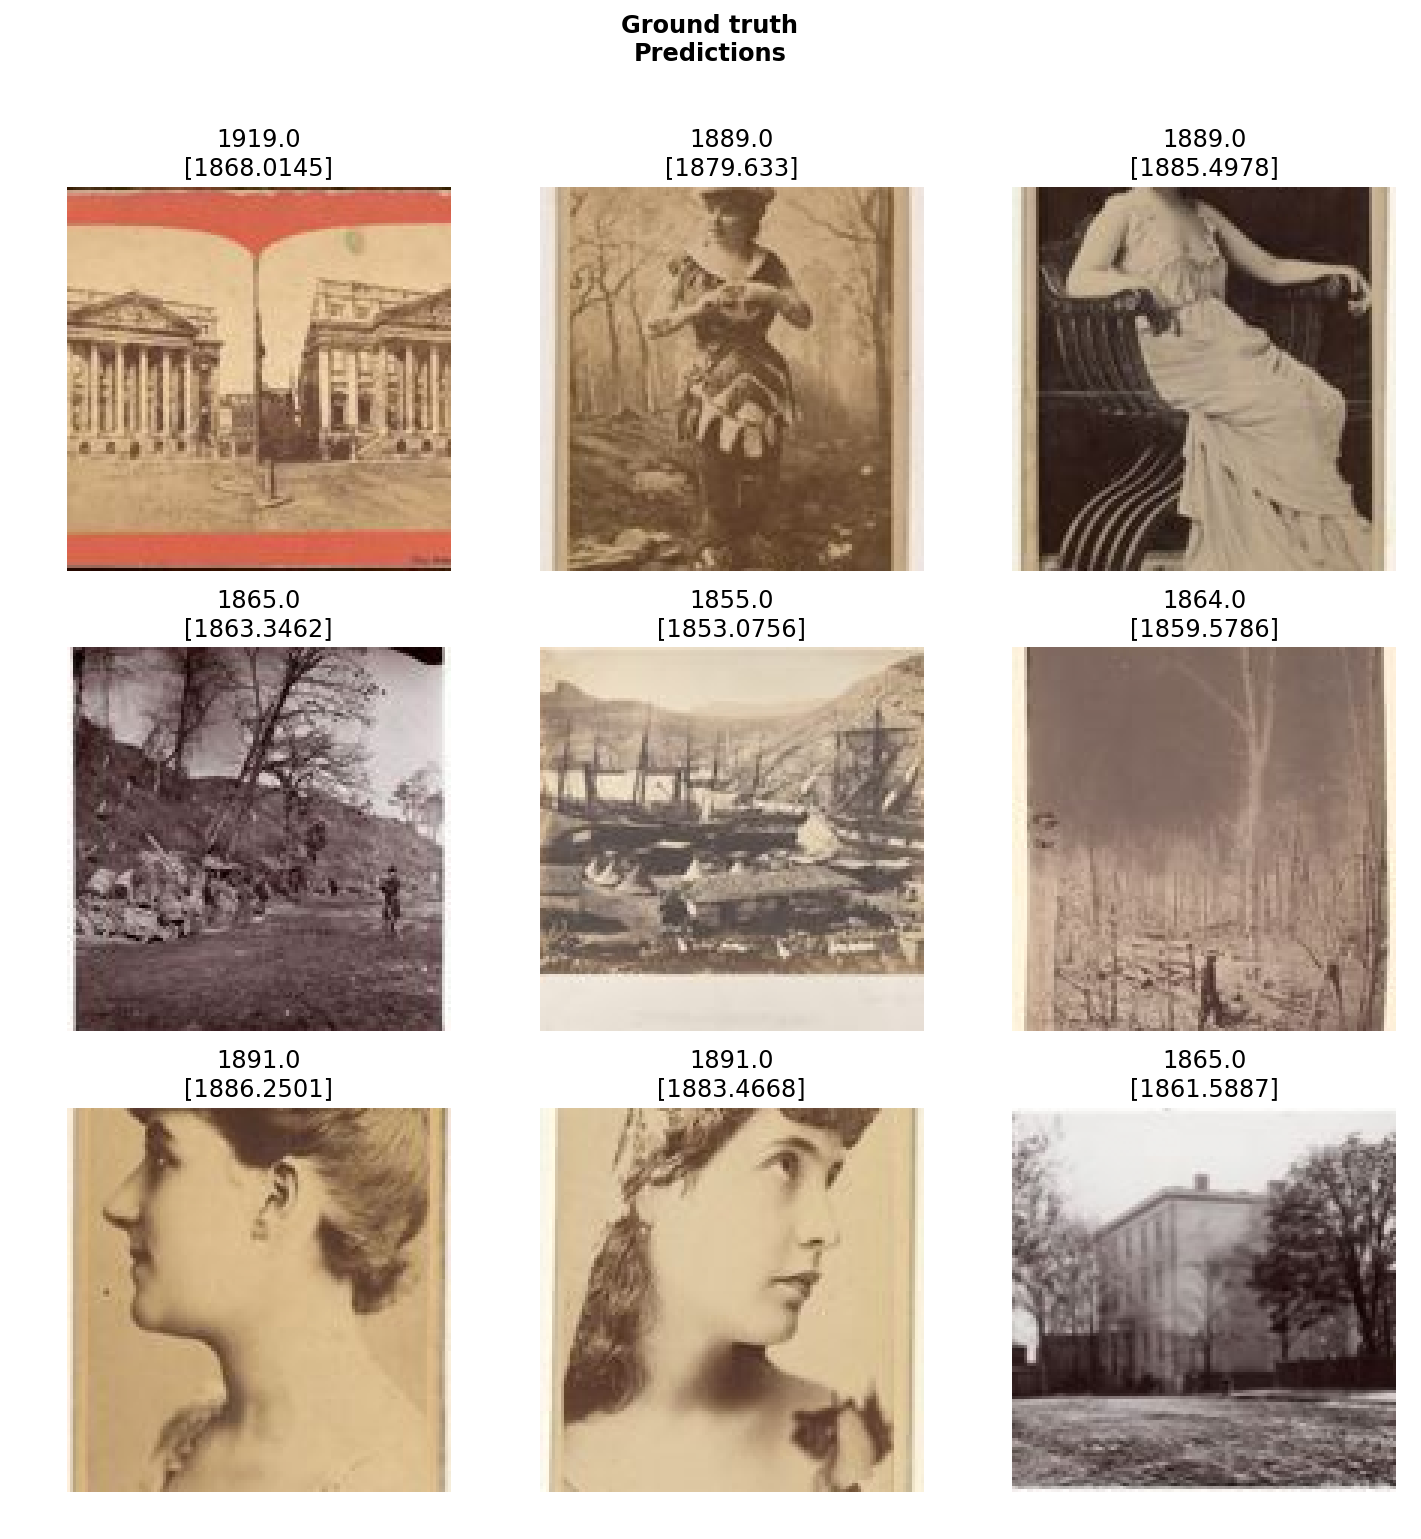

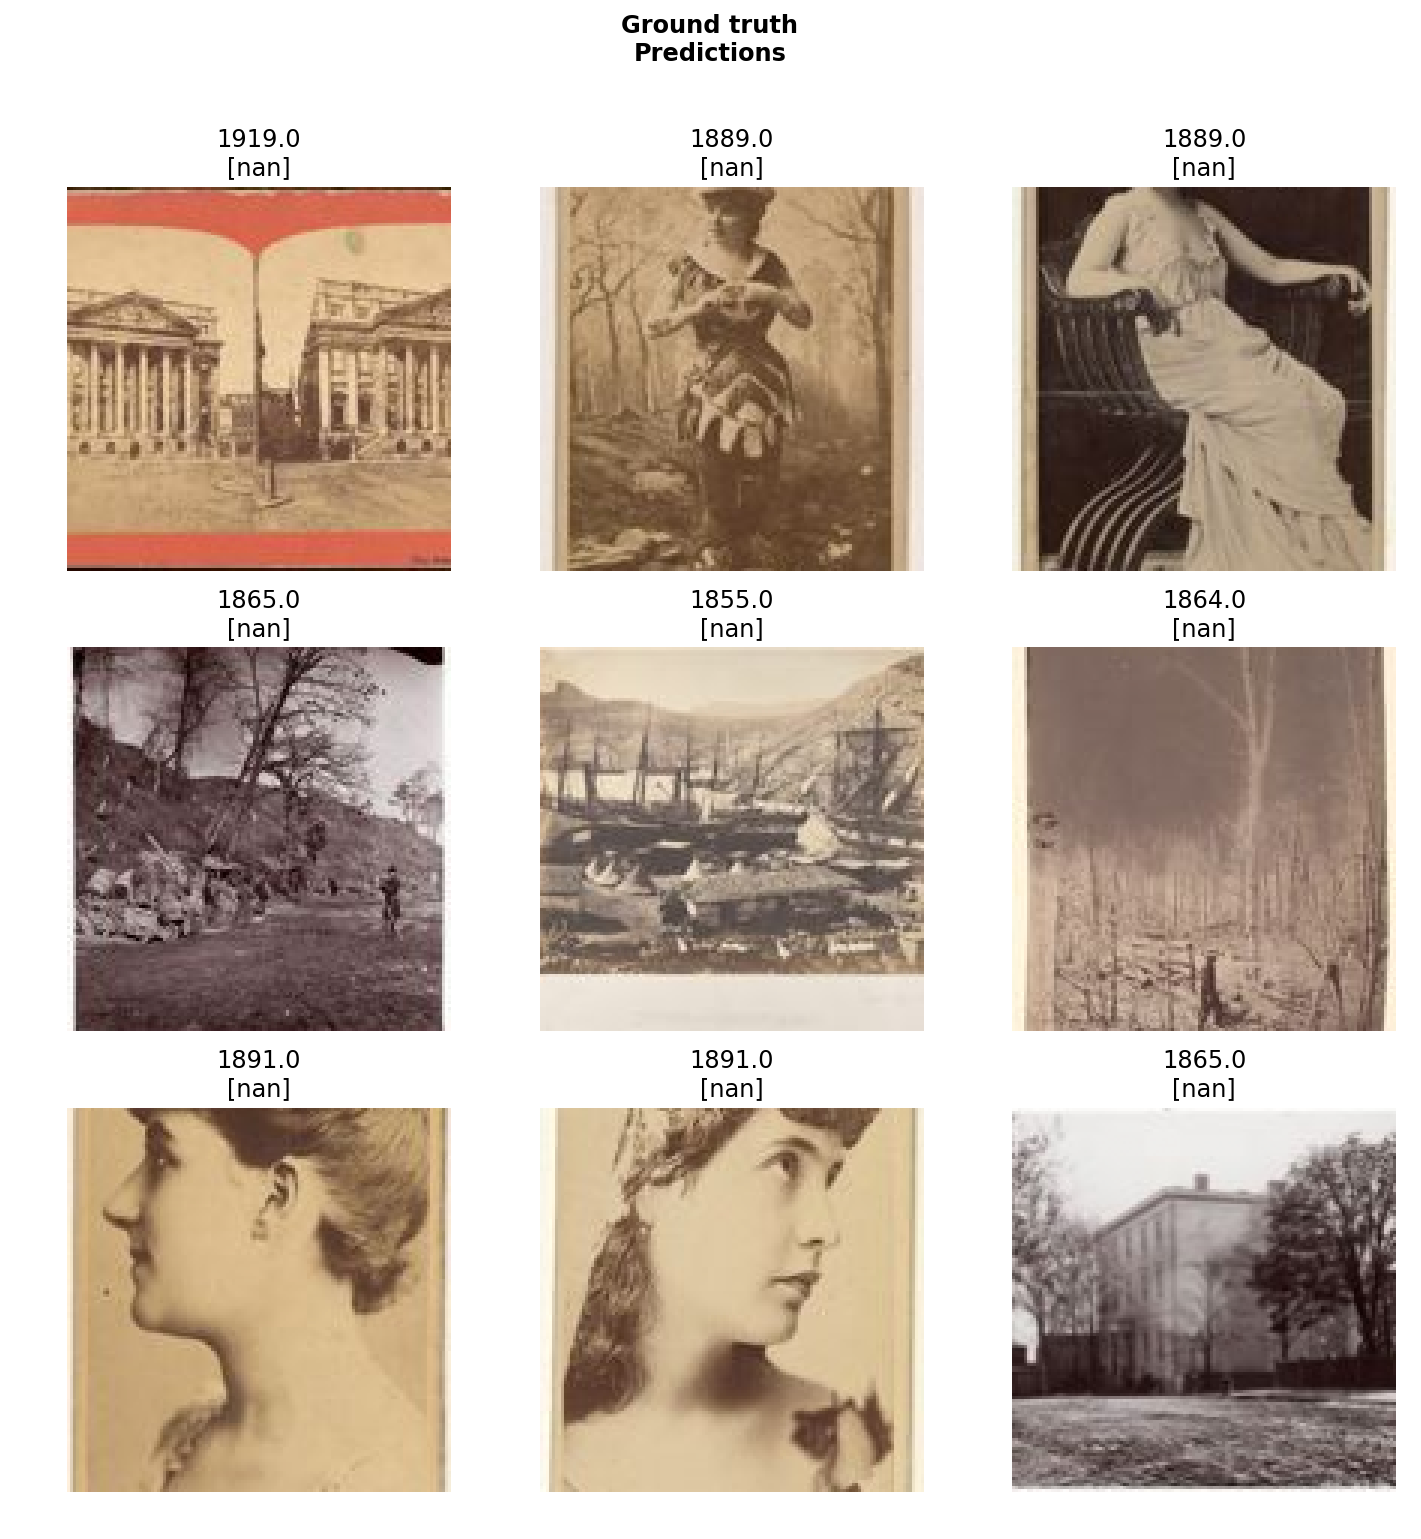

In [6]:
testing_models = [(models.resnet50, 'resnet-50'), (models.resnet101, 'resnet-101')] # (models.resnet34, 'resnet-34'), 

image_and_batch_sizes = [(64, 256), (128, 128), (256,64)]
epochs = [50,100]
learning_rates = [(1e-2, '2'), (1e-1, '1')]
pretraineds = [(True, 'w-pt')] # , (False, 'no-pt')]
random_seeds = [100]
validation_percents = [0.33]

photo_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.1, max_warp=0.2, max_rotate=20.0)

for model, image_and_batch_size, epoch, learning_rate, pretrained, random_seed, validation_percent in [( model, image_and_batch_size, epoch, learning_rate, pretrained, random_seed, validation_percent) for model in testing_models for image_and_batch_size in image_and_batch_sizes for epoch in epochs for learning_rate in learning_rates for pretrained in pretraineds for random_seed in random_seeds for validation_percent in validation_percents]:
    image_size = image_and_batch_size[0]
    batch_size = image_and_batch_size[1]
    run_name = f'when-dat-photo-v1-{model[1]}-i{image_size}-b{batch_size}-e{epoch}-l{learning_rate[1]}-{pretrained[1]}-r{random_seed}-v{validation_percent}'
    print(f'Run: {run_name}')
    fastai_image_databunch = (ImageItemList.from_df(df=met_df, path='/data/kaggle/met/', folder=f'tmp/{image_size}', cols='image_path')
                     .random_split_by_pct(valid_pct=validation_percent, seed=random_seed)
                     .label_from_df(cols='object_end_date', label_cls=FloatList)
                     .transform(photo_tfms, size=image_size)
                     .databunch(bs=batch_size))
    learn = create_cnn(fastai_image_databunch, model[0], callback_fns=ShowGraph, pretrained=pretrained[0], loss_func=root_mean_squared_error).to_fp16()
    learn.fit_one_cycle(epoch, learning_rate[0])
    learn.save(run_name)
    learn32 = learn.to_fp32()
    learn32.show_results(rows=3)

In [ ]:
doc(create_cnn)